# Influence functions wiht EK-FAC

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from support.common import plot_losses
from support.torch import TorchMLP, fit_torch_model
from pydvl.influence import compute_influence_factors, compute_influences_up
from pydvl.influence.torch import TorchTwiceDifferentiable
from support.shapley import load_wine_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [75]:
def print_error_stats(arr1, arr2, tag):
    print(f"Percentage error {tag}:{np.mean((np.abs(arr1 - arr2)/np.abs(arr2)))*100} %")
    print(f"Pearson Correlation {tag}", pearsonr(arr1, arr2))

In [69]:
input_size = 13
middle_layers = []
output_size = 3
classification = True

if classification:
    train_dataset = th.utils.data.TensorDataset(
        th.randn(100, input_size), th.randint(0, output_size, (100,))
    )
    loss = F.cross_entropy
else:
    train_dataset = th.utils.data.TensorDataset(
        th.randn(100, input_size), th.randn(100, output_size)
    )
    loss = F.mse_loss

loader = th.utils.data.DataLoader(train_dataset, batch_size=10)

layers = []
layers_size = [input_size] + middle_layers + [output_size]
for frm, to in zip(layers_size[:-1], layers_size[1:]):
    layers.append(nn.Linear(frm, to))
    layers.append(nn.Tanh())
layers.pop()
layers.append(nn.Softmax(dim=-1))
model = nn.Sequential(*layers)
model.eval()

Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): Softmax(dim=-1)
)

In [70]:
wrapped_model = TorchTwiceDifferentiable(model, loss)

In [71]:
direct_if_factors, direct_info = compute_influence_factors(
    wrapped_model,
    training_data=loader,
    test_data=loader,
    inversion_method="direct",
    hessian_perturbation=0.1,
    progress=True,
)
direct_influences = compute_influences_up(
    wrapped_model, loader, direct_if_factors, progress=True
)
mean_direct_influences = np.mean(direct_influences.numpy(), axis=0)
direct_hessian = direct_info["hessian"]

Batch Split Input Gradients: 100%|██████████| 10/10 [00:00<00:00, 215.55it/s]


In [81]:
ekfac_if_factors, ekfac_info = compute_influence_factors(
    wrapped_model,
    training_data=loader,
    test_data=loader,
    inversion_method="ekfac",
    hessian_perturbation=0.1,
    update_diag=False,
    progress=True,
)
ekfac_influences = compute_influences_up(
    wrapped_model, loader, ekfac_if_factors, progress=True
)
mean_ekfac_influences = np.mean(ekfac_influences.numpy(), axis=0)
ekfac_hessian = ekfac_info["hessian"]

Batch Test Gradients:   0%|          | 0/10 [00:00<?, ?it/s]

Batch Split Input Gradients: 100%|██████████| 10/10 [00:00<00:00, 90.53it/s]


In [82]:
print_error_stats(mean_ekfac_influences, mean_direct_influences, tag="influence values")

Percentage error influence values:76.76647305488586 %
Pearson Correlation influence values PearsonRResult(statistic=0.9713830485996867, pvalue=5.443699670068412e-63)


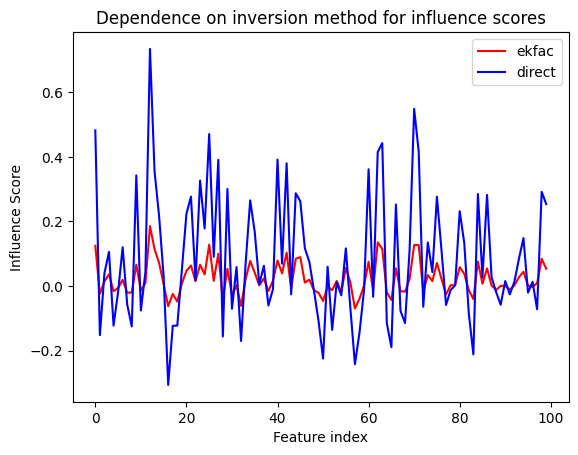

In [83]:
plt.plot(mean_ekfac_influences, color="red")
plt.plot(mean_direct_influences, color="blue")
plt.legend(["ekfac", "direct"])
plt.xlabel("Feature index")
plt.ylabel("Influence Score")
plt.title("Dependence on inversion method for influence scores")
plt.show()

In [84]:
direct_eig = np.linalg.eig(direct_hessian)[0]
ekfac_eig = np.linalg.eig(ekfac_hessian)[0]

In [85]:
print_error_stats(direct_eig.real, ekfac_eig.real, tag="eigen values")

Percentage error eigen values:93.21711659431458 %
Pearson Correlation eigen values PearsonRResult(statistic=0.47656076069529435, pvalue=0.0014200933892992147)
